# Multi-layer networks

이전 챕터에서 우리는 손으로 쓴 숫자를 분류하기 위해 Single-Layer 밀집 신경망을 사용했습니다. 이제 더 많은 Layer를 추가하면 Accuracy 측면에서 더 나은 성능을 얻을 수 있는지 살펴보겠습니다.

이전 챕터에서와 마찬가지로 `pytorchcv`를 사용하여 이전 챕터에서 정의한 모든 함수를 불러옵니다.

In [7]:
import torch
import torch.nn as nn
import torchvision
import matplotlib.pyplot as plt
from torchinfo import summary

from pytorchcv import load_mnist, train, plot_results
load_mnist(batch_size=128)

## Multi-layer perceptron

Multi-Layer 네트워크는 **Hidden Layer**를 1개 이상 추가합니다.

![An image showing a multi-layer network with a hidden layer between the input layer and the output layer.](./images/dense-multilayer-network.png)

이 Layer에는 신경망이 얼마나 강력한지, 즉 얼마나 많은 매개 변수를 가질지에 따라 영향을 미치는 뉴런이 얼마든지 포함될 수 있으며, 네트워크에 매개 변수가 많을수록 훈련하는 데 더 많은 데이터가 필요합니다.

그러나 _more_ 가 항상 _better_ 는 아닙니다. **과적합**을 방지하기 위해 데이터 세트 크기에 따라 신경망의 여러 파라미터를 선택해야합니다.

네트워크 구조는 다음과 같습니다.

![An image showing the network layer structure as it's broken down into layers.](./images/multilayer-network-layers.png)

여기서 주목해야 할 중요한 점은 **ReLU**라고 하는 비선형 활성화 함수 Layer입니다. 신경망이 높은 표현력을 달성하는 이유 중 하나이기 때문에 이러한 비선형 활성화 함수를 도입하는 것은 중요합니다. 실제로 네트워크가 일련의 선형 Layer로만 구성된 경우 본질적으로 하나의 선형 Layer와 동일하다는 것을 수학적으로 증명할 수 있습니다. 따라서 Layer 사이에 비선형 함수를 추가하는 것이 중요합니다!

다음은 가장 자주 사용되는 두 가지 활성화 함수의 모습입니다.

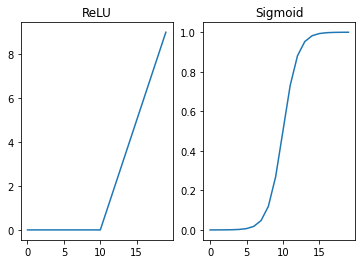

In [8]:
def plot_function(f,name=''):
    plt.plot([f(torch.tensor(x,dtype=torch.float32)).item() for x in range(-10,10)])
    plt.title(name)

plt.subplot(121)
plot_function(torch.relu,'ReLU')
plt.subplot(122)
plot_function(torch.sigmoid,'Sigmoid')

네트워크는 `Sequential` 구문을 사용하여 다음과 같은 방식으로 PyTorch에서 정의할 수 있습니다.

In [9]:
net = nn.Sequential(
        nn.Flatten(), 
        nn.Linear(784,100),     # 784 inputs, 100 outputs
        nn.ReLU(),              # Activation Function
        nn.Linear(100,10),      # 100 inputs, 10 outputs
        nn.LogSoftmax())

summary(net,input_size=(1,28,28))

Layer (type:depth-idx)                   Output Shape              Param #
├─Flatten: 1-1                           [1, 784]                  --
├─Linear: 1-2                            [1, 100]                  78,500
├─ReLU: 1-3                              [1, 100]                  --
├─Linear: 1-4                            [1, 10]                   1,010
├─LogSoftmax: 1-5                        [1, 10]                   --
Total params: 79,510
Trainable params: 79,510
Non-trainable params: 0
Total mult-adds (M): 0.08
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.32
Estimated Total Size (MB): 0.32

`torchsummary.summary()` 함수를 사용하여 다른 유용한 정보와 함께 네트워크의 상세한 레이어별 구조를 표시합니다. 특히 네트워크의 파라미터 개수를 볼 수 있습니다.

이제 Multi-Layer Perceptron을 훈련시켜 보겠습니다.

Epoch  0, Train acc=0.923, Val acc=0.954, Train loss=0.002, Val loss=0.001
Epoch  1, Train acc=0.962, Val acc=0.958, Train loss=0.001, Val loss=0.001
Epoch  2, Train acc=0.969, Val acc=0.954, Train loss=0.001, Val loss=0.001
Epoch  3, Train acc=0.975, Val acc=0.966, Train loss=0.001, Val loss=0.001
Epoch  4, Train acc=0.977, Val acc=0.968, Train loss=0.001, Val loss=0.001


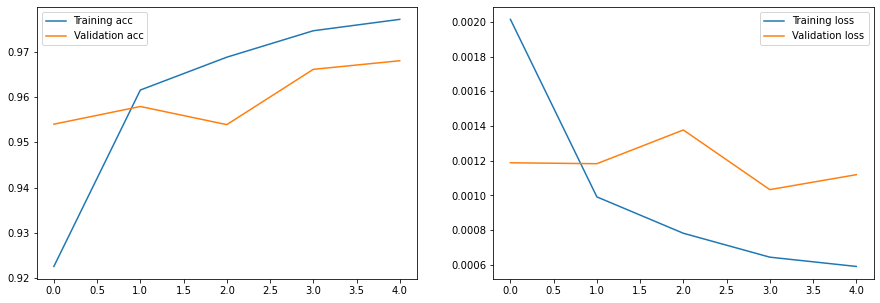

In [10]:
hist = train(net,train_loader,test_loader, epochs=5)
plot_results(hist)

아래 사항을 유의하십시오

 * 이 네트워크는 이전 챕터에서 훈련한 Single-Layer Perceptron보다 더 표현력이 뛰어납니다. 따라서 훨씬 더 높은 훈련 Accuracy를 달성하고 충분히 많은 수의 매개 변수가 주어지면 거의 100%에 도달 할 수 있습니다.
 * 검증 Accuracy가 더 이상 증가하지 않으면 모델이 일반화할 수있는 능력에 도달했음을 의미하며, 추가 훈련으로 인해 과적합이 발생할 가능성이 있습니다.

## Class-based network definitions

`Sequential` 스타일을 Layer로 사용하여 모델을 정의하는 것은 매우 편리해보이지만 다소 제한적입니다. 어떤 점에서는 공유 가중치(shared weights)를 포함하는 더 복잡한 네트워크 또는 Layer 간의 일부 비선형 연결을 정의해야 할 수도 있습니다.

In [5]:
from torch.nn.functional import relu,log_softmax

class MyNet(nn.Module):
    def __init__(self):
        super(MyNet, self).__init__()
        self.flatten = nn.Flatten()
        self.hidden = nn.Linear(784,100)
        self.out = nn.Linear(100,10)

    def forward(self, x):
        x = self.flatten(x)
        x = self.hidden(x)
        x = relu(x)
        x = self.out(x)
        x = log_softmax(x)
        return x

net = MyNet()

summary(net,input_size=(1,28,28))

/anaconda/envs/py37_pytorch/lib/python3.7/site-packages/ipykernel_launcher.py:15: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  from ipykernel import kernelapp as app


Layer (type:depth-idx)                   Output Shape              Param #
├─Flatten: 1-1                           [1, 784]                  --
├─Linear: 1-2                            [1, 100]                  78,500
├─Linear: 1-3                            [1, 10]                   1,010
Total params: 79,510
Trainable params: 79,510
Non-trainable params: 0
Total mult-adds (M): 0.08
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.32
Estimated Total Size (MB): 0.32

위 신경망의 구조는 `Sequential`의 네트워크와 동일하지만, 네트워크 구조에 대한 정의는 더 명확하다는 것을 알 수 있습니다. 사용자 정의 신경망은 [``torch.nn.Module``](https://pytorch.org/docs/stable/generated/torch.nn.Module.html) 클래스에서 상속된 클래스로 표현됩니다.

클래스 정의는 두 부분으로 구성됩니다.
* constructor(`__init__`)에서 네트워크가 가질 모든 Layer를 정의합니다. 이러한 Layer는 클래스의 내부 변수로 저장되며 PyTorch는 학습시 해당 Layer의 매개 변수를 최적화해야 하는 것을 자동으로 인식합니다. 내부적으로 PyTorch는 `parameters ()` 메소드를 사용하여 모든 학습 가능한 파라미터를 찾고, `nn.Module`은 모든 하위 모듈에서 학습 가능한 모든 파라미터를 자동으로 수집합니다.
* 신경망의 순방향 전달 계산을 수행하는 `forward` 방법을 정의합니다. 파라미터 Tensor `x`로 시작하여 `flatten`에서 시작하여 최종 선형 Layer인 `out`까지 모든 Layer와 활성화 함수를 통해 명시적으로 전달합니다. `out = net (x)`를 작성하여 일부 입력 데이터 `x`에 신경망을 적용할 때`forward` 메소드가 호출됩니다.

실제로 `Sequential` 네트워크는 이와 매우 유사한 방식으로 표현되며, Layer 목록을 저장하고 순방향 전달 계산을 수행하는 중에 순차적으로 적용합니다. 여기서 이 프로세스를 보다 명시적으로 표현함으로써 결과적으로 더 많은 유연성을 제공합니다. 이것이 신경망 정의를 위해 클래스를 사용하는 것이 권장되고 추론되는 이유 중 하나입니다.

이제 네트워크를 훈련시키고 이전과 비슷한 결과를 얻도록 할 것입니다.

/anaconda/envs/py37_pytorch/lib/python3.7/site-packages/ipykernel_launcher.py:15: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  from ipykernel import kernelapp as app


Epoch  0, Train acc=0.923, Val acc=0.953, Train loss=0.002, Val loss=0.001
Epoch  1, Train acc=0.962, Val acc=0.964, Train loss=0.001, Val loss=0.001
Epoch  2, Train acc=0.970, Val acc=0.953, Train loss=0.001, Val loss=0.001
Epoch  3, Train acc=0.975, Val acc=0.955, Train loss=0.001, Val loss=0.001
Epoch  4, Train acc=0.978, Val acc=0.964, Train loss=0.001, Val loss=0.001


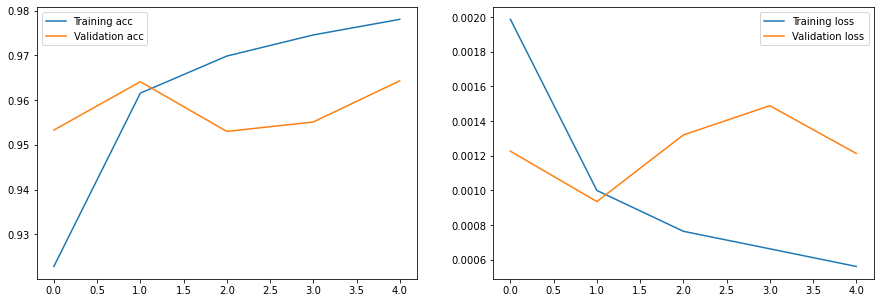

In [6]:
hist = train(net,train_loader,test_loader,epochs=5)
plot_results(hist)

## Takeaway

Multi-Level Networks는 Single-Layer Perceptron보다 더 높은 정확도를 달성할 수 있지만 컴퓨터 비전 작업에는 적합하지 않습니다. 이미지에는 이미지의 위치에 관계없이 개체를 분류하는 데 도움이 되는 구조적 패턴이 있지만, Perceptron은 이러한 패턴을 추출하여 선택적으로 찾을 수 없습니다. 다음 단원에서는 컴퓨터 비전 작업에 효과적으로 사용할 수있는 특별한 유형의 신경망에 초점을 맞출 것입니다.